# **📊 Yurak-qon tomir kasalliklari statistikasi**

<a id="colab-link" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<script>
  (function() {
    let url = window.location.href;
    // Ищем ссылку на github
    if (url.includes("github.com")) {
      url = url.replace("github.com", "colab.research.google.com/github");
      document.getElementById("colab-link").href = url;
    }
  })();
</script>

## **1-qadam. Kutubxonalarni chaqirish**

Bizga kerak:  
- `requests` — WHO GHO API’dan so‘rov yuborish  
- `pandas` — ma’lumotlarni jadvalga aylantirish  
- `matplotlib` — grafik chizish

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

## **2-qadam. Indikator kodlarini tekshirish va tanlash**

WHO GHO indikator ro‘yxatini olib, yurak-qon tomir kasalliklari bilan bog‘liq kodlarni topamiz, masalan:  
- `NCDMORT3070` — 30–70 yosh oralig‘ida yurak/qon tomir va boshqa NCD kasalliklari tufayli o‘lish ehtimoli (%)  
- `WHOSIS_000001` — Umr davomiyligi (life expectancy)

In [ ]:
# Tanlangan indikator kodlari va sarlavhalar
indikatorlar  = {
    "NCDMORT3070": "30–70 yoshdagi NCD o'limi (%)",
    "WHOSIS_000001": "O'rtacha umr ko'rish davomiyligi (yil)"
}

## **3-qadam. Ma’lumotlarni yuklab olish (butun dunyo, 2000–2024)**

Har bir indikator uchun WHO GHO API’dan ma’lumot olib, `WLD` (global) bo‘yicha filtrlash va yillar oralig‘ini ushlab qolamiz.


In [ ]:
df_list = []

for kod, nom in indikatorlar.items():
    url = f"https://ghoapi.azureedge.net/api/{kod}?$format=json"
    javob = requests.get(url).json()

    # Agar ma’lumot bo‘sh bo‘lsa, o'tkazib yuboramiz
    if "value" not in javob or len(javob["value"]) == 0:
        print(f"{kod} uchun ma’lumot topilmadi")
        continue

    df = pd.json_normalize(javob["value"])

    # Faqat GLOBAL darajani olish
    df = df[df["SpatialDim"] == "GLOBAL"]

    # Ustunlarni qoldirish
    df = df[["TimeDim", "NumericValue"]].rename(
        columns={"TimeDim": "Yil", "NumericValue": nom}
    )

    # Group by year and calculate the mean
    df = df.groupby("Yil")[nom].mean().reset_index()

    df_list.append(df)

## **4-qadam. Jadvalni shakllantirish**

Yillar kesimida barcha ko‘rsatkichlarni bitta jadvalga qo‘shamiz.

In [ ]:
birlashtirilgan = df_list[0]
for df in df_list[1:]:
    birlashtirilgan = pd.merge(birlashtirilgan, df, on="Yil", how="outer")

## **5-qadam. Oraliqni tanlash**

2000–2024 yillar oralig‘ini ko‘rib chiqamiz.

In [ ]:
# Yillar bo‘yicha tartiblash
birlashtirilgan = birlashtirilgan.sort_values("Yil").reset_index(drop=True)

#Faqat 2000–2024 oralig‘ini olish
birlashtirilgan = birlashtirilgan[
    (birlashtirilgan["Yil"] >= 2000) & (birlashtirilgan["Yil"] <= 2024)
]
print(birlashtirilgan.head(15))

     Yil  30–70 yoshdagi NCD o'limi (%)  \
0   2000                      22.533333   
1   2001                      22.233333   
2   2002                      22.100000   
3   2003                      21.933333   
4   2004                      21.533333   
5   2005                      21.200000   
6   2006                      20.633333   
7   2007                      20.266667   
8   2008                      20.066667   
9   2009                      19.733333   
10  2010                      19.600000   
11  2011                      19.333333   
12  2012                      19.033333   
13  2013                      18.700000   
14  2014                      18.500000   

    O'rtacha umr ko'rish davomiyligi (yil)  
0                                66.793047  
1                                67.121424  
2                                67.381113  
3                                67.641592  
4                                67.979023  
5                                68.41387

## **6-qadam. Grafik chizish**

Har ikkala ko‘rsatkichni yagona grafikda chizamiz.

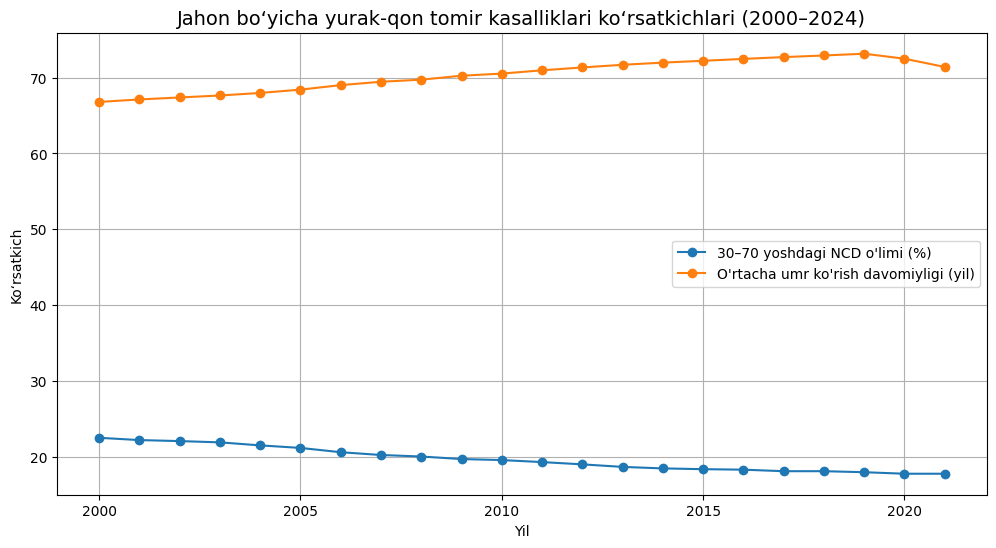

In [ ]:
plt.figure(figsize=(12, 6))

for ustun in birlashtirilgan.columns:
    if ustun != "Yil":
        plt.plot(
            birlashtirilgan["Yil"],
            birlashtirilgan[ustun],
            marker="o",
            label=ustun
        )

plt.title("Jahon bo‘yicha yurak-qon tomir kasalliklari ko‘rsatkichlari (2000–2024)", fontsize=14)
plt.xlabel("Yil")
plt.ylabel("Ko‘rsatkich")
plt.legend()
plt.grid(True)
plt.show()